In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import random
import cv2
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 5
from numpy.random import seed
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Read the training and test images 

In [3]:
# read the training and test data sets (source: Kaggle)
TRAIN_DIR = '/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week7/dogs-vs-cats-redux-kernels-edition/train/'
TEST_DIR = '/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week7/dogs-vs-cats-redux-kernels-edition/test/'

cat_dog_labels = []
train = []
for i in os.listdir(TRAIN_DIR):
    train.append(i)
    if 'dog' in i:
        cat_dog_labels.append(1)
    else:
        cat_dog_labels.append(0)
        
test = []
for i in os.listdir(TEST_DIR):
    test.append(i)
    
print ('Number of train images: ')
print (len(train))

print ('Number of dog labels: ')
print (sum(x for x in cat_dog_labels if (x == 1)))

print ('Number of cat labels: ')
print (sum(1 for x in cat_dog_labels if (x == 0)))

print ('Number of test images: ')
print (len(test))

Number of train images: 
25000
Number of dog labels: 
12500
Number of cat labels: 
12500
Number of test images: 
12500


Text(0.5, 1.0, 'Cats and Dogs labels in the training data')

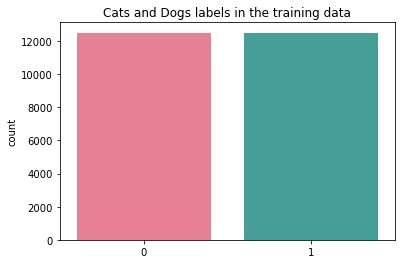

In [4]:
# Count plot of the labels in training data 
sns.countplot(cat_dog_labels, palette="husl")
plt.title('Cats and Dogs labels in the training data')

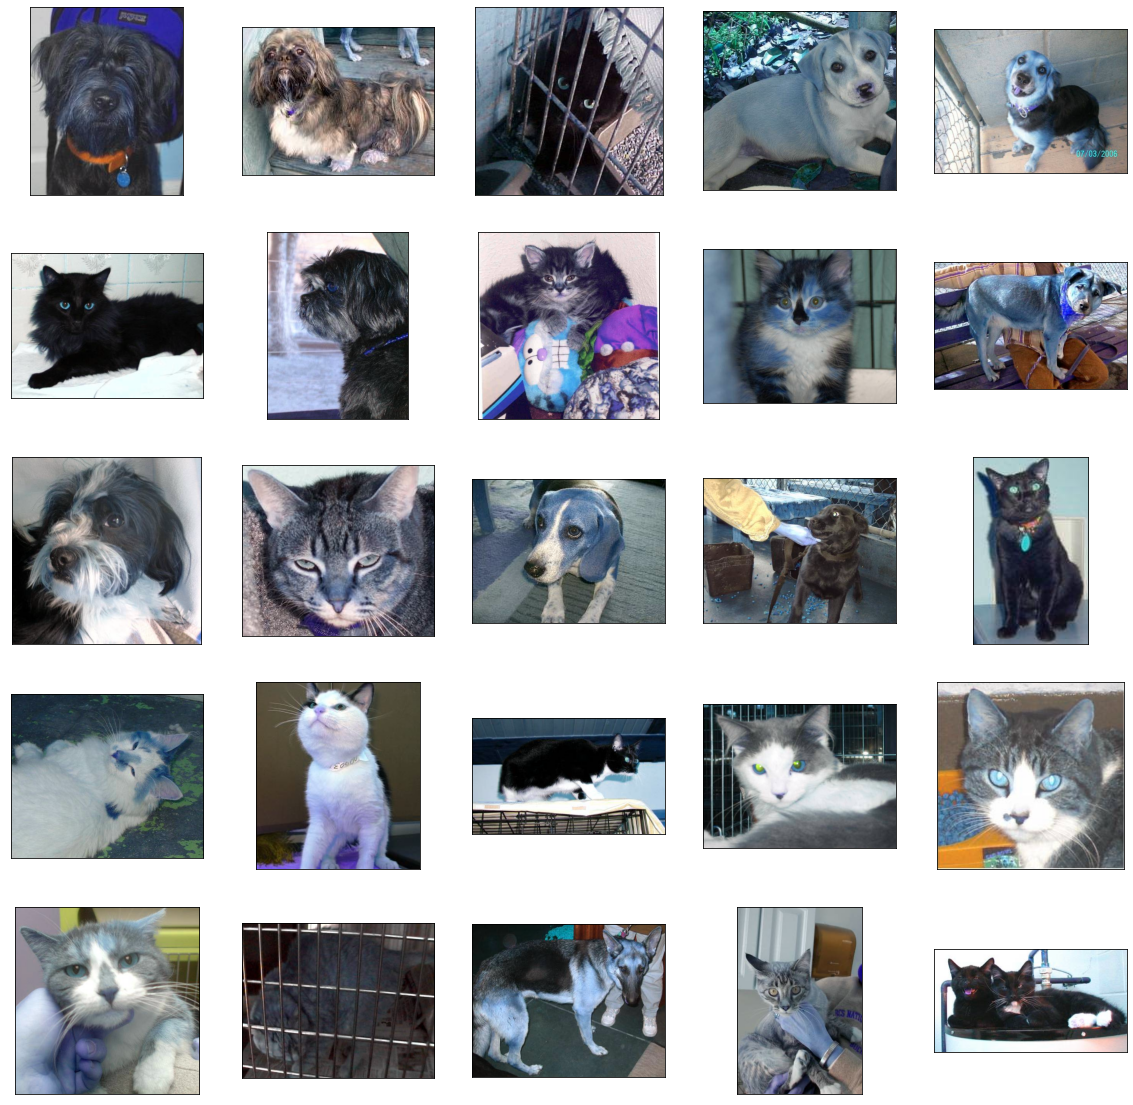

In [5]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=random.randint(0, len(train))
    image_file_path = os.path.join(TRAIN_DIR, train[j])
    img = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    plt.imshow(img)
plt.show()

In [6]:
# Convert image to numpy array... 
# Three channels for color converted to grayscale
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
# Convert image to numpy array... three channels for color
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

def show_color_image(image):
    plt.imshow(image) 
    plt.axis('off')
    plt.show()   

In [7]:
#Create a dataframe to store the model accuracy and scores
results_tbl = pd.DataFrame(columns=['Model_name','Image resolution (factor1)','Number of channels (factor2)', 'Hidden activation function (factor3)','Mini-batch size (factor4)','Processing Time','Training Set Accuracy','Validation Set Accuracy','Test Set Log-Loss (Kaggle score)'])
results_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Model_name                            0 non-null      object
 1   Image resolution (factor1)            0 non-null      object
 2   Number of channels (factor2)          0 non-null      object
 3   Hidden activation function (factor3)  0 non-null      object
 4   Mini-batch size (factor4)             0 non-null      object
 5   Processing Time                       0 non-null      object
 6   Training Set Accuracy                 0 non-null      object
 7   Validation Set Accuracy               0 non-null      object
 8   Test Set Log-Loss (Kaggle score)      0 non-null      object
dtypes: object(9)
memory usage: 0.0+ bytes


# Two level factorial experiment design with 4 factors

# Create 64x64 images in color

In [8]:
# ----------------------------------------------------------------------
print('\nProcessing train image files to 64x64 color arrays')
# Create train_images_25000_64_64_3 and numpy array for images in color
train_images_25000_64_64_3 = np.zeros((len(train), 64, 64, 3))  
for ifile in range(len(train)):
    image_file_path = os.path.join(TRAIN_DIR, train[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    train_images_25000_64_64_3[ifile,:,:,:] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(train)))
print('Processed 25000 of 25000')


Processing train image files to 64x64 color arrays
Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 25000 of 25000


In [9]:
outdir = '/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week7/dogs-vs-cats-redux-kernels-edition/cats_dogs_arrays/'
#os.mkdir(outdir)    
       
np.save(os.path.join(outdir, 'train_images_25000_64_64_3.npy'), train_images_25000_64_64_3)

In [10]:
# Create test_images_12500_64_64_3 and numpy array for images in color
print('\nProcessing test image files to 64x64 color arrays')
test_images_12500_64_64_3 = np.zeros((len(test), 64, 64, 3))  
for ifile in range(len(test)):
    image_file_path = os.path.join(TEST_DIR, test[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    test_images_12500_64_64_3[ifile,:,:,:] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(test)))
print('Processed 12500 of 12500')


Processing test image files to 64x64 color arrays
Processed 0 of 12500
Processed 2500 of 12500
Processed 5000 of 12500
Processed 7500 of 12500
Processed 10000 of 12500
Processed 12500 of 12500


In [11]:
np.save(os.path.join(outdir, 'test_images_12500_64_64_3.npy'), test_images_12500_64_64_3)

In [12]:
# Normalize the data 
X_valid, X_train = train_images_25000_64_64_3[:5000] / 255.0, train_images_25000_64_64_3[5000:] / 255.0
y_valid, y_train = cat_dog_labels[:5000], cat_dog_labels[5000:]
X_test = test_images_12500_64_64_3 / 255.0

In [13]:
#Reshape the data for model training
X_train = X_train.reshape(X_train.shape[0], 64, 64,3).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0], 64, 64,3).astype('float32')

In [14]:
#Reshape the data for prediction
X_test = X_test.reshape(X_test.shape[0], 64, 64,3).astype('float32')

In [15]:
X_train.shape

(20000, 64, 64, 3)

In [16]:
X_valid.shape

(5000, 64, 64, 3)

In [17]:
X_test.shape

(12500, 64, 64, 3)

# <font color="green">_Treatment 1_</font> 

## image resolution: 64x64
## number of channels: 3 (RGB)
## hidden Activation function: ReLu
## mini-batch size: 32 

In [18]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0

In [20]:
model_1.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [21]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_1 = model_1.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 43s 68ms/step - loss: 0.6897 - accuracy: 0.5280 - val_loss: 0.6802 - val_accuracy: 0.5824
Epoch 2/15
625/625 [==============================] - 46s 73ms/step - loss: 0.6651 - accuracy: 0.5943 - val_loss: 0.6296 - val_accuracy: 0.6428
Epoch 3/15
625/625 [==============================] - 45s 72ms/step - loss: 0.5987 - accuracy: 0.6794 - val_loss: 0.5646 - val_accuracy: 0.7208
Epoch 4/15
625/625 [==============================] - 47s 75ms/step - loss: 0.5550 - accuracy: 0.7178 - val_loss: 0.5198 - val_accuracy: 0.7456
Epoch 5/15
625/625 [==============================] - 48s 76ms/step - loss: 0.5207 - accuracy: 0.7447 - val_loss: 0.5170 - val_accuracy: 0.7456
Epoch 6/15
625/625 [==============================] - 48s 77ms/step - loss: 0.4911 - accuracy: 0.7637 - val_loss: 0.5225 - val_accuracy: 0.7386
Epoch 7/15
625/625 [==============================] - 49s 78ms/step - loss: 0.4806 - accuracy: 0.7699 - val_loss: 0.4520 - val_accuracy:

In [22]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_1.history['accuracy'][np.argmin(history_1.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8329

In [23]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_1.history['val_accuracy'][np.argmin(history_1.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8378

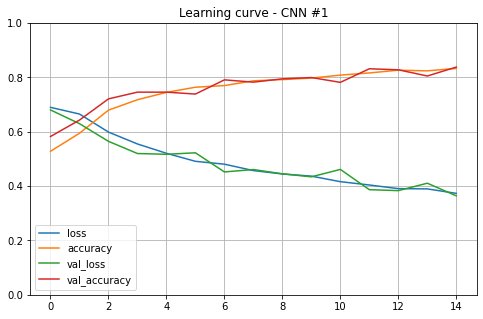

In [24]:
# Plot the learning curve
pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #1')
plt.show()

In [25]:
predict_1 = model_1.predict(X_test)

In [26]:
predict_1

array([[0.09310171],
       [0.34591806],
       [0.9441869 ],
       ...,
       [0.5941845 ],
       [0.01321089],
       [0.9999025 ]], dtype=float32)

In [27]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_1)})
submission_df.to_csv('submission_model_1.csv',index=False)

In [28]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #1', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.31343'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343


# <font color="green">_Treatment 2_</font> 

## image resolution: 64x64
## number of channels: 3 (RGB)
## hidden Activation function: ReLu
## mini-batch size: 256


In [29]:
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [30]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)        

In [31]:
model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [32]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_2 = model_2.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 37s 473ms/step - loss: 0.6945 - accuracy: 0.5124 - val_loss: 0.6942 - val_accuracy: 0.4984
Epoch 2/15
79/79 [==============================] - 39s 494ms/step - loss: 0.6833 - accuracy: 0.5487 - val_loss: 0.6693 - val_accuracy: 0.5764
Epoch 3/15
79/79 [==============================] - 37s 464ms/step - loss: 0.6448 - accuracy: 0.6250 - val_loss: 0.6938 - val_accuracy: 0.5238
Epoch 4/15
79/79 [==============================] - 41s 519ms/step - loss: 0.6103 - accuracy: 0.6661 - val_loss: 0.5720 - val_accuracy: 0.7042
Epoch 5/15
79/79 [==============================] - 39s 496ms/step - loss: 0.5523 - accuracy: 0.7186 - val_loss: 0.5266 - val_accuracy: 0.7556
Epoch 6/15
79/79 [==============================] - 36s 462ms/step - loss: 0.5045 - accuracy: 0.7541 - val_loss: 0.4766 - val_accuracy: 0.7732
Epoch 7/15
79/79 [==============================] - 36s 461ms/step - loss: 0.4806 - accuracy: 0.7718 - val_loss: 0.5257 - val_accuracy: 0.7218

In [33]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_2.history['accuracy'][np.argmin(history_2.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8591

In [34]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_2.history['val_accuracy'][np.argmin(history_2.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8574

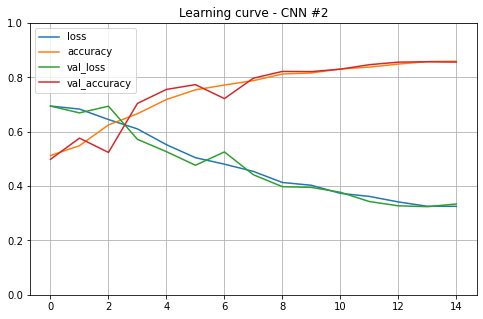

In [35]:
# Plot the learning curve
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #2')
plt.show()

In [36]:
predict_2 = model_2.predict(X_test)
predict_2

array([[0.01723632],
       [0.18110257],
       [0.9387449 ],
       ...,
       [0.7160171 ],
       [0.02503678],
       [0.99992037]], dtype=float32)

In [37]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_2)})
submission_df.to_csv('submission_model_2.csv',index=False)

In [38]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #2', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.40166'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166


# <font color="green">_Treatment 3_</font> 

## image resolution: 64x64
## number of channels: 3 (RGB)
## hidden Activation function: Tanh
## mini-batch size: 32

In [39]:
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [40]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)        

In [41]:
model_3.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [42]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_3 = model_3.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 55s 89ms/step - loss: 0.6360 - accuracy: 0.6370 - val_loss: 0.5721 - val_accuracy: 0.6970
Epoch 2/15
625/625 [==============================] - 55s 87ms/step - loss: 0.5473 - accuracy: 0.7226 - val_loss: 0.5371 - val_accuracy: 0.7372
Epoch 3/15
625/625 [==============================] - 57s 91ms/step - loss: 0.5066 - accuracy: 0.7518 - val_loss: 0.5368 - val_accuracy: 0.7416
Epoch 4/15
625/625 [==============================] - 58s 92ms/step - loss: 0.4755 - accuracy: 0.7731 - val_loss: 0.4606 - val_accuracy: 0.7790
Epoch 5/15
625/625 [==============================] - 56s 89ms/step - loss: 0.4546 - accuracy: 0.7876 - val_loss: 0.4872 - val_accuracy: 0.7742
Epoch 6/15
625/625 [==============================] - 54s 87ms/step - loss: 0.4259 - accuracy: 0.8019 - val_loss: 0.4150 - val_accuracy: 0.8108
Epoch 7/15
625/625 [==============================] - 54s 86ms/step - loss: 0.4123 - accuracy: 0.8113 - val_loss: 0.4192 - val_accuracy:

In [43]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_3.history['accuracy'][np.argmin(history_3.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8456

In [44]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_3.history['val_accuracy'][np.argmin(history_3.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.848

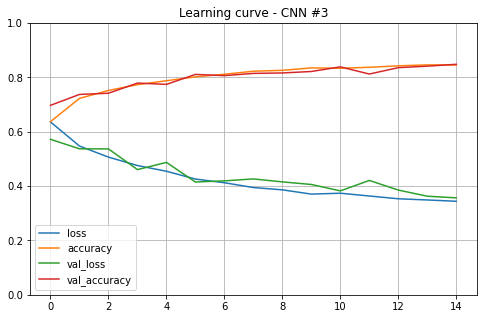

In [45]:
# Plot the learning curve
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #3')
plt.show()

In [46]:
predict_3 = model_3.predict(X_test)
predict_3

array([[0.35316914],
       [0.40769854],
       [0.9456765 ],
       ...,
       [0.05491126],
       [0.0032098 ],
       [0.9886451 ]], dtype=float32)

In [47]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_3)})
submission_df.to_csv('submission_model_3.csv',index=False)

In [48]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #3', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.46957'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957


# <font color="green">_Treatment 4_</font> 

## image resolution: 64x64
## number of channels: 3 (RGB)
## hidden Activation function: Tanh
## mini-batch size :256

In [49]:
model_4 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [50]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)        

In [51]:
model_4.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [52]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_4 = model_4.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 37s 470ms/step - loss: 0.6774 - accuracy: 0.5964 - val_loss: 0.6525 - val_accuracy: 0.6226
Epoch 2/15
79/79 [==============================] - 37s 468ms/step - loss: 0.5976 - accuracy: 0.6820 - val_loss: 0.5955 - val_accuracy: 0.6754
Epoch 3/15
79/79 [==============================] - 39s 498ms/step - loss: 0.5588 - accuracy: 0.7144 - val_loss: 0.5544 - val_accuracy: 0.7194
Epoch 4/15
79/79 [==============================] - 40s 501ms/step - loss: 0.5255 - accuracy: 0.7412 - val_loss: 0.4901 - val_accuracy: 0.7630
Epoch 5/15
79/79 [==============================] - 40s 504ms/step - loss: 0.4923 - accuracy: 0.7673 - val_loss: 0.4726 - val_accuracy: 0.7724
Epoch 6/15
79/79 [==============================] - 39s 499ms/step - loss: 0.4679 - accuracy: 0.7772 - val_loss: 0.4462 - val_accuracy: 0.7862
Epoch 7/15
79/79 [==============================] - 38s 481ms/step - loss: 0.4299 - accuracy: 0.8011 - val_loss: 0.8110 - val_accuracy: 0.6162

In [53]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_4.history['accuracy'][np.argmin(history_4.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.8591

In [54]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_4.history['val_accuracy'][np.argmin(history_4.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8366

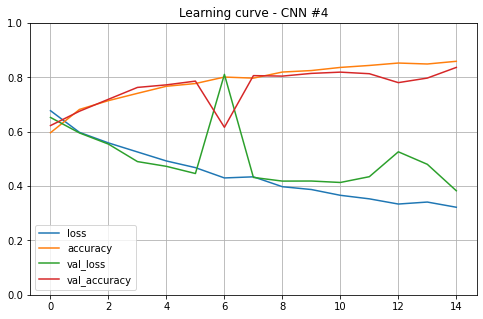

In [55]:
# Plot the learning curve
pd.DataFrame(history_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #4')
plt.show()

In [56]:
predict_4 = model_4.predict(X_test)
predict_4

array([[0.05012771],
       [0.8176433 ],
       [0.9480357 ],
       ...,
       [0.23519969],
       [0.01105481],
       [0.99374104]], dtype=float32)

In [57]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_4)})
submission_df.to_csv('submission_model_4.csv',index=False)

In [58]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #4', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.43507'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507


# create 128X128 images in color

In [59]:
# ----------------------------------------------------------------------
print('\nProcessing train image files to 128x128 color arrays')
# Create train_images_25000_128_128_3 and numpy array for images in color
train_images_25000_128_128_3 = np.zeros((len(train), 128, 128, 3))  
for ifile in range(len(train)):
    image_file_path = os.path.join(TRAIN_DIR, train[ifile])
    image = parse_color_and_resize(image_file_path, size = (128, 128))
    train_images_25000_128_128_3[ifile,:,:,:] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(train)))
print('Processed 25000 of 25000')



Processing train image files to 128x128 color arrays
Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 25000 of 25000


In [60]:
np.save(os.path.join(outdir, 'train_images_25000_128_128_3.npy'), train_images_25000_128_128_3)

In [61]:
# Create test_images_12500_128_128_3 and numpy array for images in color
print('\nProcessing test image files to 128x128 color arrays')
test_images_12500_128_128_3 = np.zeros((len(test), 128, 128, 3))  
for ifile in range(len(test)):
    image_file_path = os.path.join(TEST_DIR, test[ifile])
    image = parse_color_and_resize(image_file_path, size = (128, 128))
    test_images_12500_128_128_3[ifile,:,:,:] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(test)))
print('Processed 12500 of 12500')


Processing test image files to 128x128 color arrays
Processed 0 of 12500
Processed 2500 of 12500
Processed 5000 of 12500
Processed 7500 of 12500
Processed 10000 of 12500
Processed 12500 of 12500


In [62]:
np.save(os.path.join(outdir, 'test_images_12500_128_128_3.npy'), test_images_12500_128_128_3)

In [63]:
# Normalize the data 
X_valid, X_train = train_images_25000_128_128_3[:5000] / 255.0, train_images_25000_128_128_3[5000:] / 255.0
y_valid, y_train = cat_dog_labels[:5000], cat_dog_labels[5000:]
X_test = test_images_12500_128_128_3 / 255.0


In [64]:
#Reshape the data for model training
X_train = X_train.reshape(X_train.shape[0], 128, 128,3).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0], 128, 128,3).astype('float32')


In [65]:
#Reshape the data for prediction
X_test = X_test.reshape(X_test.shape[0], 128, 128,3).astype('float32')


In [66]:
X_train.shape

(20000, 128, 128, 3)

In [67]:
X_valid.shape

(5000, 128, 128, 3)

In [68]:
X_test.shape

(12500, 128, 128, 3)


# <font color="green">_Treatment 5_</font> 
 
## image resolution: 128x128
## number of channels: 3 (RGB)
## hidden Activation function: ReLu
## mini-batch size: 32 

In [69]:
model_5 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[128, 128, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [70]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 128)      

In [71]:
model_5.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [72]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_5 = model_5.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 174s 278ms/step - loss: 0.6379 - accuracy: 0.6218 - val_loss: 0.5926 - val_accuracy: 0.6822
Epoch 2/15
625/625 [==============================] - 179s 286ms/step - loss: 0.5282 - accuracy: 0.7340 - val_loss: 0.4864 - val_accuracy: 0.7690
Epoch 3/15
625/625 [==============================] - 181s 290ms/step - loss: 0.4497 - accuracy: 0.7871 - val_loss: 0.4114 - val_accuracy: 0.8158
Epoch 4/15
625/625 [==============================] - 186s 297ms/step - loss: 0.3990 - accuracy: 0.8172 - val_loss: 0.3808 - val_accuracy: 0.8364
Epoch 5/15
625/625 [==============================] - 177s 283ms/step - loss: 0.3716 - accuracy: 0.8300 - val_loss: 0.3485 - val_accuracy: 0.8490
Epoch 6/15
625/625 [==============================] - 181s 290ms/step - loss: 0.3403 - accuracy: 0.8496 - val_loss: 0.3244 - val_accuracy: 0.8662
Epoch 7/15
625/625 [==============================] - 184s 294ms/step - loss: 0.3241 - accuracy: 0.8560 - val_loss: 0.3010 -

In [73]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_5.history['accuracy'][np.argmin(history_5.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.9111

In [74]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_5.history['val_accuracy'][np.argmin(history_5.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.9134

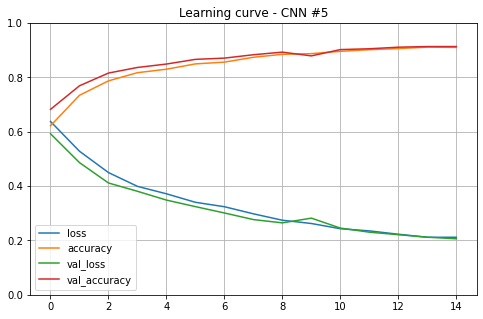

In [75]:
# Plot the learning curve
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #5')
plt.show()

In [76]:

predict_5 = model_5.predict(X_test)
predict_5

array([[3.9038953e-01],
       [6.1590701e-01],
       [9.3183869e-01],
       ...,
       [6.2082791e-01],
       [6.0892105e-04],
       [9.9999982e-01]], dtype=float32)

In [77]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_5)})
submission_df.to_csv('submission_model_5.csv',index=False)

In [78]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #5', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '2.71841'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841



# <font color="green">_Treatment 6_</font> 
 
## image resolution: 128x128
## number of channels: 3 (RGB)
## hidden Activation function: ReLu
## mini-batch size: 256

In [81]:
model_6 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[128, 128, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [82]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 128)      

In [83]:

model_6.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [84]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_6 = model_6.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 168s 2s/step - loss: 0.7209 - accuracy: 0.5049 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 2/15
79/79 [==============================] - 170s 2s/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 3/15
79/79 [==============================] - 164s 2s/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 4/15
79/79 [==============================] - 161s 2s/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 5/15
79/79 [==============================] - 160s 2s/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 6/15
79/79 [==============================] - 159s 2s/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 7/15
79/79 [==============================] - 160s 2s/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 8/15
79

In [85]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_6.history['accuracy'][np.argmin(history_6.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.5004

In [86]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_6.history['val_accuracy'][np.argmin(history_6.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.5016

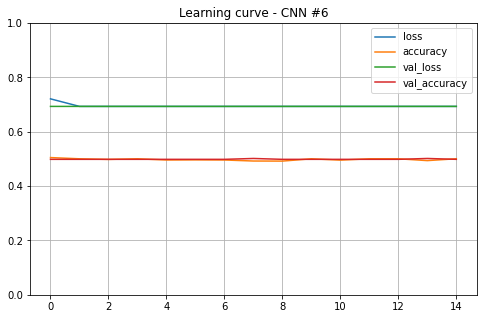

In [87]:
# Plot the learning curve
pd.DataFrame(history_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #6')
plt.show()

In [88]:

predict_6 = model_6.predict(X_test)
predict_6

array([[0.49858502],
       [0.49858502],
       [0.49858502],
       ...,
       [0.49858502],
       [0.49858502],
       [0.49858502]], dtype=float32)

In [89]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_6)})
submission_df.to_csv('submission_model_6.csv',index=False)

In [90]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #6', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '0.69315'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315


# <font color="green">_Treatment 7_</font> 
 
## image resolution: 128x128
## number of channels: 3 (RGB)
## hidden Activation function: Tanh
## mini-batch size: 32

In [91]:
model_7 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[128, 128, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [92]:
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 128)      

In [93]:
model_7.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [94]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_7 = model_7.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 208s 333ms/step - loss: 0.6277 - accuracy: 0.6612 - val_loss: 0.5660 - val_accuracy: 0.6994
Epoch 2/15
625/625 [==============================] - 195s 313ms/step - loss: 0.5349 - accuracy: 0.7303 - val_loss: 0.5646 - val_accuracy: 0.7050
Epoch 3/15
625/625 [==============================] - 194s 311ms/step - loss: 0.5756 - accuracy: 0.6990 - val_loss: 0.5823 - val_accuracy: 0.6824
Epoch 4/15
625/625 [==============================] - 242s 386ms/step - loss: 0.6701 - accuracy: 0.5502 - val_loss: 0.6937 - val_accuracy: 0.5018
Epoch 5/15
625/625 [==============================] - 197s 315ms/step - loss: 0.6954 - accuracy: 0.5056 - val_loss: 0.6947 - val_accuracy: 0.5018
Epoch 6/15
625/625 [==============================] - 208s 332ms/step - loss: 0.6953 - accuracy: 0.4981 - val_loss: 0.6972 - val_accuracy: 0.4984
Epoch 7/15
625/625 [==============================] - 203s 325ms/step - loss: 0.6958 - accuracy: 0.4982 - val_loss: 0.7021 -

In [95]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_7.history['accuracy'][np.argmin(history_7.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7303

In [96]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_7.history['val_accuracy'][np.argmin(history_7.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.705

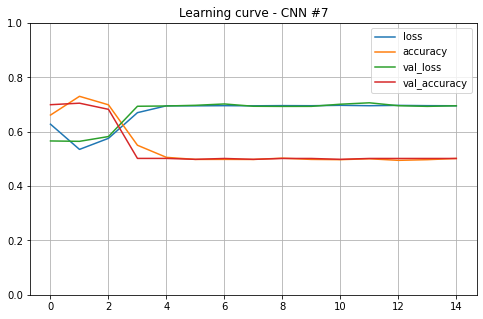

In [97]:
# Plot the learning curve
pd.DataFrame(history_7.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #7')
plt.show()


In [98]:
predict_7 = model_7.predict(X_test)
predict_7


array([[0.5351997],
       [0.5351997],
       [0.5351997],
       ...,
       [0.5351997],
       [0.5351997],
       [0.5351997]], dtype=float32)

In [99]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_7)})
submission_df.to_csv('submission_model_7.csv',index=False)

In [100]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #7', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '0.69562'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562


# <font color="green">_Treatment 8_</font> 
  
## image resolution: 128x128
## number of channels: 3 (RGB)
## hidden Activation function: Tanh
## mini-batch size: 256

In [101]:
model_8 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[128, 128, 3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [102]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 128)      

In [103]:
model_8.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [105]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_8 = model_8.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 184s 2s/step - loss: 0.2909 - accuracy: 0.8741 - val_loss: 0.3692 - val_accuracy: 0.8450
Epoch 2/15
79/79 [==============================] - 184s 2s/step - loss: 0.2790 - accuracy: 0.8784 - val_loss: 0.3778 - val_accuracy: 0.8500
Epoch 3/15
79/79 [==============================] - 182s 2s/step - loss: 0.2754 - accuracy: 0.8794 - val_loss: 0.3848 - val_accuracy: 0.8408
Epoch 4/15
79/79 [==============================] - 178s 2s/step - loss: 0.2565 - accuracy: 0.8915 - val_loss: 0.3429 - val_accuracy: 0.8564
Epoch 5/15
79/79 [==============================] - 178s 2s/step - loss: 0.2330 - accuracy: 0.9014 - val_loss: 0.3623 - val_accuracy: 0.8572
Epoch 6/15
79/79 [==============================] - 194s 2s/step - loss: 0.2196 - accuracy: 0.9082 - val_loss: 0.3362 - val_accuracy: 0.8684
Epoch 7/15
79/79 [==============================] - 186s 2s/step - loss: 0.2036 - accuracy: 0.9153 - val_loss: 0.3939 - val_accuracy: 0.8472
Epoch 8/15
79

In [106]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_8.history['accuracy'][np.argmin(history_8.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.9355

In [107]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_8.history['val_accuracy'][np.argmin(history_8.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8676

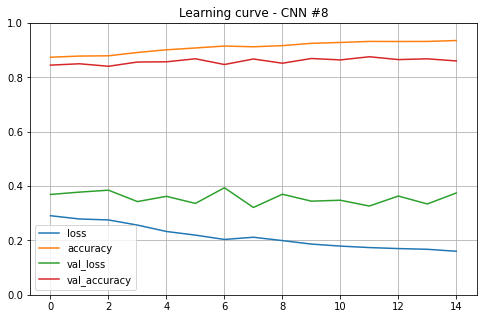

In [108]:
# Plot the learning curve
pd.DataFrame(history_8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #8')
plt.show()

In [109]:
predict_8 = model_8.predict(X_test)
predict_8

array([[3.0355459e-01],
       [9.7201884e-01],
       [9.1785753e-01],
       ...,
       [8.1504691e-01],
       [2.6968122e-04],
       [9.9989700e-01]], dtype=float32)

In [110]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_8)})
submission_df.to_csv('submission_model_8.csv',index=False)


In [111]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #8', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'3',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '2.39295'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295


# Create 64x64 images in grayscale color

In [113]:
print('\nProcessing train image files to 64x64 grayscale arrays')
# Create train_images_25000_64_64_1 and numpy array for images in grayscale
train_images_25000_64_64_1 = np.zeros((len(train), 64, 64, 1))  
for ifile in range(len(train)):
    image_file_path = os.path.join(TRAIN_DIR, train[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    train_images_25000_64_64_1[ifile,:,:,0] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(train)))
print('Processed 25000 of 25000')


Processing train image files to 64x64 grayscale arrays
Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 25000 of 25000


In [114]:
np.save(os.path.join(outdir, 'train_images_25000_64_64_1.npy'), train_images_25000_64_64_1)

In [115]:
# Create test_images_12500_64_64_1 and numpy array for images in color
print('\nProcessing test image files to 64x64 grayscale arrays')
test_images_12500_64_64_1 = np.zeros((len(test), 64, 64, 1))  
for ifile in range(len(test)):
    image_file_path = os.path.join(TEST_DIR, test[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    test_images_12500_64_64_1[ifile,:,:,0] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(test)))
print('Processed 12500 of 12500')



Processing test image files to 64x64 grayscale arrays
Processed 0 of 12500
Processed 2500 of 12500
Processed 5000 of 12500
Processed 7500 of 12500
Processed 10000 of 12500
Processed 12500 of 12500


In [116]:
np.save(os.path.join(outdir, 'test_images_12500_64_64_1.npy'), test_images_12500_64_64_1)


In [117]:
# Normalize the data 
X_valid, X_train = train_images_25000_64_64_1[:5000] / 255.0, train_images_25000_64_64_1[5000:] / 255.0
y_valid, y_train = cat_dog_labels[:5000], cat_dog_labels[5000:]
X_test = test_images_12500_64_64_1 / 255.0


In [118]:
#Reshape the data for model training
X_train = X_train.reshape(X_train.shape[0], 64, 64,1).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0], 64, 64,1).astype('float32')

In [119]:
#Reshape the data for prediction
X_test = X_test.reshape(X_test.shape[0], 64, 64,1).astype('float32')

In [120]:
X_train.shape

(20000, 64, 64, 1)

In [121]:
X_valid.shape

(5000, 64, 64, 1)

In [122]:
X_test.shape

(12500, 64, 64, 1)


# <font color="green">_Treatment 9_</font> 

## image resolution: 64x64
## number of channels: 1 (Grayscale)
## hidden Activation function: ReLu
## mini-batch size: 32 

In [124]:
model_9 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


In [125]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 128)        

In [126]:
model_9.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [127]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_9 = model_9.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 40s 64ms/step - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.6933 - val_accuracy: 0.4984
Epoch 2/15
625/625 [==============================] - 42s 66ms/step - loss: 0.6928 - accuracy: 0.4990 - val_loss: 0.6867 - val_accuracy: 0.5480
Epoch 3/15
625/625 [==============================] - 42s 67ms/step - loss: 0.6891 - accuracy: 0.5325 - val_loss: 0.6804 - val_accuracy: 0.5554
Epoch 4/15
625/625 [==============================] - 40s 64ms/step - loss: 0.6740 - accuracy: 0.5788 - val_loss: 0.6547 - val_accuracy: 0.6238
Epoch 5/15
625/625 [==============================] - 42s 66ms/step - loss: 0.6390 - accuracy: 0.6359 - val_loss: 0.6027 - val_accuracy: 0.6746
Epoch 6/15
625/625 [==============================] - 41s 66ms/step - loss: 0.6068 - accuracy: 0.6704 - val_loss: 0.5934 - val_accuracy: 0.6844
Epoch 7/15
625/625 [==============================] - 41s 65ms/step - loss: 0.5738 - accuracy: 0.7030 - val_loss: 0.5456 - val_accuracy:

In [128]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_9.history['accuracy'][np.argmin(history_9.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.7862

In [129]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_9.history['val_accuracy'][np.argmin(history_9.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.8024

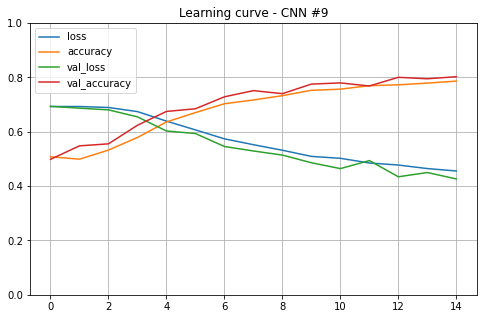

In [130]:
# Plot the learning curve
pd.DataFrame(history_9.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #9')
plt.show()

In [131]:
predict_9 = model_9.predict(X_test)

In [132]:
predict_9

array([[0.24398243],
       [0.7874267 ],
       [0.8759111 ],
       ...,
       [0.3432547 ],
       [0.35267162],
       [0.99604475]], dtype=float32)

In [133]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_9)})
submission_df.to_csv('submission_model_9.csv',index=False)

In [134]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #9', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.05215'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215


# <font color="green">_Treatment 10_</font> 
 
## image resolution: 64x64
## number of channels: 1 (Grayscale)
## hidden Activation function: ReLu
## mini-batch size: 256
 

In [136]:
model_10 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


In [137]:
model_10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 6, 6, 128)        

In [138]:
model_10.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [139]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_10 = model_10.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 34s 427ms/step - loss: 0.6818 - accuracy: 0.5529 - val_loss: 0.6598 - val_accuracy: 0.6040
Epoch 2/15
79/79 [==============================] - 34s 434ms/step - loss: 0.6416 - accuracy: 0.6295 - val_loss: 0.6089 - val_accuracy: 0.6736
Epoch 3/15
79/79 [==============================] - 33s 423ms/step - loss: 0.5941 - accuracy: 0.6827 - val_loss: 0.5519 - val_accuracy: 0.7354
Epoch 4/15
79/79 [==============================] - 34s 436ms/step - loss: 0.5383 - accuracy: 0.7335 - val_loss: 0.5080 - val_accuracy: 0.7556
Epoch 5/15
79/79 [==============================] - 36s 458ms/step - loss: 0.4883 - accuracy: 0.7673 - val_loss: 0.4682 - val_accuracy: 0.7776
Epoch 6/15
79/79 [==============================] - 35s 437ms/step - loss: 0.4532 - accuracy: 0.7903 - val_loss: 0.4576 - val_accuracy: 0.7780
Epoch 7/15
79/79 [==============================] - 33s 420ms/step - loss: 0.4310 - accuracy: 0.8026 - val_loss: 0.5070 - val_accuracy: 0.7594

In [140]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_10.history['accuracy'][np.argmin(history_10.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.8633

In [141]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_10.history['val_accuracy'][np.argmin(history_10.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.8614

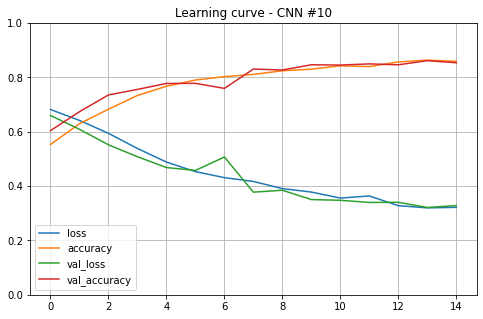

In [142]:
# Plot the learning curve
pd.DataFrame(history_10.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #10')
plt.show()

In [143]:
predict_10 = model_10.predict(X_test)
predict_10

array([[0.04915231],
       [0.7579813 ],
       [0.93007374],
       ...,
       [0.15321717],
       [0.02701482],
       [0.9449233 ]], dtype=float32)

In [144]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_10)})
submission_df.to_csv('submission_model_10.csv',index=False)

In [145]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #10', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.40932'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


 
# <font color="green">_Treatment 11_</font> 
 
## image resolution: 64x64
## number of channels: 1 (Grayscale)
## hidden Activation function: Tanh
## mini-batch size: 32 

In [146]:
model_11 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [147]:
model_11.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 6, 128)       

In [148]:
model_11.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [149]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_11 = model_11.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
625/625 [==============================] - 46s 73ms/step - loss: 0.6335 - accuracy: 0.6352 - val_loss: 0.5617 - val_accuracy: 0.7134
Epoch 2/15
625/625 [==============================] - 46s 73ms/step - loss: 0.5363 - accuracy: 0.7327 - val_loss: 0.5038 - val_accuracy: 0.7578
Epoch 3/15
625/625 [==============================] - 46s 73ms/step - loss: 0.5046 - accuracy: 0.7568 - val_loss: 0.5294 - val_accuracy: 0.7464
Epoch 4/15
625/625 [==============================] - 45s 72ms/step - loss: 0.4663 - accuracy: 0.7784 - val_loss: 0.4423 - val_accuracy: 0.7902
Epoch 5/15
625/625 [==============================] - 46s 74ms/step - loss: 0.4407 - accuracy: 0.7962 - val_loss: 0.5055 - val_accuracy: 0.7666
Epoch 6/15
625/625 [==============================] - 46s 74ms/step - loss: 0.4183 - accuracy: 0.8058 - val_loss: 0.4162 - val_accuracy: 0.8166
Epoch 7/15
625/625 [==============================] - 46s 73ms/step - loss: 0.4041 - accuracy: 0.8136 - val_loss: 0.3956 - val_accuracy:

In [150]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_11.history['accuracy'][np.argmin(history_11.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.8529

In [151]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_11.history['val_accuracy'][np.argmin(history_11.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.836

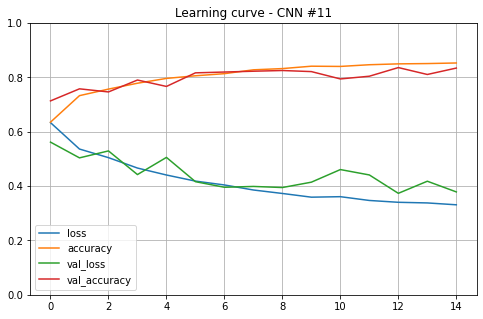

In [152]:
# Plot the learning curve
pd.DataFrame(history_11.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #11')
plt.show()


In [153]:
predict_11 = model_11.predict(X_test)
predict_11

array([[0.18320134],
       [0.39056128],
       [0.96148396],
       ...,
       [0.25493866],
       [0.00708702],
       [0.9907458 ]], dtype=float32)

In [154]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_11)})
submission_df.to_csv('submission_model_11.csv',index=False)

In [155]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #11', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.37364'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


# <font color="green">_Treatment 12_</font> 
   
## image resolution: 64x64
## number of channels: 1 (Grayscale)
## hidden Activation function: Tanh
## mini-batch size: 256

In [156]:
model_12 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [157]:
model_12.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 6, 128)       

In [158]:
model_12.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [159]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_12 = model_12.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 36s 460ms/step - loss: 0.6899 - accuracy: 0.5758 - val_loss: 0.6317 - val_accuracy: 0.6474
Epoch 2/15
79/79 [==============================] - 35s 443ms/step - loss: 0.6123 - accuracy: 0.6625 - val_loss: 0.6235 - val_accuracy: 0.6502
Epoch 3/15
79/79 [==============================] - 36s 456ms/step - loss: 0.5715 - accuracy: 0.7034 - val_loss: 0.5460 - val_accuracy: 0.7206
Epoch 4/15
79/79 [==============================] - 35s 443ms/step - loss: 0.5159 - accuracy: 0.7482 - val_loss: 0.4913 - val_accuracy: 0.7700
Epoch 5/15
79/79 [==============================] - 35s 447ms/step - loss: 0.4894 - accuracy: 0.7676 - val_loss: 0.4960 - val_accuracy: 0.7666
Epoch 6/15
79/79 [==============================] - 36s 459ms/step - loss: 0.4643 - accuracy: 0.7793 - val_loss: 0.4536 - val_accuracy: 0.7780
Epoch 7/15
79/79 [==============================] - 36s 460ms/step - loss: 0.4397 - accuracy: 0.7933 - val_loss: 0.9815 - val_accuracy: 0.6032

In [160]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_12.history['accuracy'][np.argmin(history_12.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8539

In [161]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_12.history['val_accuracy'][np.argmin(history_12.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.833

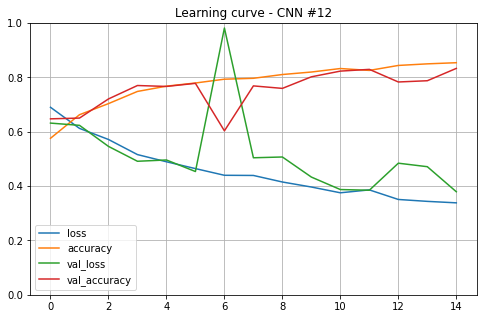

In [162]:
# Plot the learning curve
pd.DataFrame(history_12.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #12')
plt.show()

In [163]:
predict_12 = model_12.predict(X_test)
predict_12


array([[0.23981604],
       [0.5405801 ],
       [0.7923186 ],
       ...,
       [0.3210243 ],
       [0.03772953],
       [0.9923167 ]], dtype=float32)

In [164]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_12)})
submission_df.to_csv('submission_model_12.csv',index=False)


In [165]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #12', 
                                   'Image resolution (factor1)':'64x64',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.34496'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


# Create 128x128 images in grayscale color

In [166]:
print('\nProcessing train image files to 128x128 grayscale arrays')
# Create train_images_25000_128_128_1 and numpy array for images in grayscale
train_images_25000_128_128_1 = np.zeros((len(train), 128, 128, 1))  
for ifile in range(len(train)):
    image_file_path = os.path.join(TRAIN_DIR, train[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (128,128))
    train_images_25000_128_128_1[ifile,:,:,0] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(train)))
print('Processed 25000 of 25000')



Processing train image files to 128x128 grayscale arrays
Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 25000 of 25000


In [167]:
np.save(os.path.join(outdir, 'train_images_25000_128_128_1.npy'), train_images_25000_128_128_1)

In [168]:
# Create test_images_12500_128_128_1 and numpy array for images in grayscale
print('\nProcessing test image files to 128x128 grayscale arrays')
test_images_12500_128_128_1 = np.zeros((len(test), 128, 128, 1))  
for ifile in range(len(test)):
    image_file_path = os.path.join(TEST_DIR, test[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (128, 128))
    test_images_12500_128_128_1[ifile,:,:,0] = image
    if ifile%2500 == 0: print('Processed {} of {}'.format(ifile, len(test)))
print('Processed 12500 of 12500')


Processing test image files to 128x128 grayscale arrays
Processed 0 of 12500
Processed 2500 of 12500
Processed 5000 of 12500
Processed 7500 of 12500
Processed 10000 of 12500
Processed 12500 of 12500


In [169]:
np.save(os.path.join(outdir, 'test_images_12500_128_128_1.npy'), test_images_12500_128_128_1)

In [170]:
# Normalize the data 
X_valid, X_train = train_images_25000_128_128_1[:5000] / 255.0, train_images_25000_128_128_1[5000:] / 255.0
y_valid, y_train = cat_dog_labels[:5000], cat_dog_labels[5000:]
X_test = test_images_12500_128_128_1 / 255.0

In [171]:

#Reshape the data for model training
X_train = X_train.reshape(X_train.shape[0], 128, 128,1).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0],128, 128,1).astype('float32')


In [172]:
#Reshape the data for prediction
X_test = X_test.reshape(X_test.shape[0], 128, 128,1).astype('float32')


In [173]:
X_train.shape

(20000, 128, 128, 1)

In [174]:
X_valid.shape

(5000, 128, 128, 1)

In [175]:
X_test.shape

(12500, 128, 128, 1)

# <font color="green">_Treatment 13_</font> 

## image resolution: 128x128
## number of channels: 1 (Grayscale)
## hidden Activation function: ReLu
## mini-batch size: 32 

In [176]:
model_13 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[128, 128, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [177]:
model_13.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 14, 14, 128)     

In [178]:
model_13.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [179]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_13 = model_13.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)


Epoch 1/15
625/625 [==============================] - 190s 304ms/step - loss: 0.6923 - accuracy: 0.5145 - val_loss: 0.6933 - val_accuracy: 0.4984
Epoch 2/15
625/625 [==============================] - 183s 293ms/step - loss: 0.6927 - accuracy: 0.5092 - val_loss: 0.6907 - val_accuracy: 0.4972
Epoch 3/15
625/625 [==============================] - 184s 295ms/step - loss: 0.6930 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 4/15
625/625 [==============================] - 183s 292ms/step - loss: 0.6926 - accuracy: 0.5056 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 5/15
625/625 [==============================] - 181s 290ms/step - loss: 0.6892 - accuracy: 0.5371 - val_loss: 0.6854 - val_accuracy: 0.5774
Epoch 6/15
625/625 [==============================] - 182s 291ms/step - loss: 0.6864 - accuracy: 0.5490 - val_loss: 0.6934 - val_accuracy: 0.5028
Epoch 7/15
625/625 [==============================] - 182s 291ms/step - loss: 0.6803 - accuracy: 0.5760 - val_loss: 0.6786 -

In [180]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_13.history['accuracy'][np.argmin(history_13.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8396

In [181]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_13.history['val_accuracy'][np.argmin(history_13.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8484

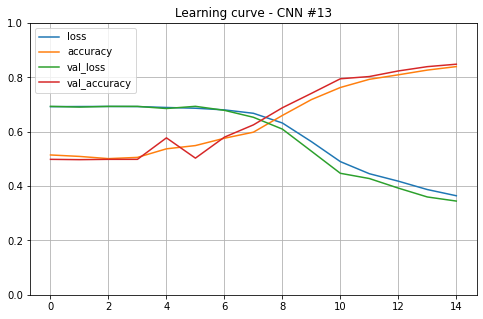

In [182]:
# Plot the learning curve
pd.DataFrame(history_13.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #13')
plt.show()


In [183]:
predict_13 = model_13.predict(X_test)
predict_13

array([[0.19548625],
       [0.8730611 ],
       [0.7095953 ],
       ...,
       [0.6530338 ],
       [0.02967331],
       [0.9991026 ]], dtype=float32)

In [184]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_13)})
submission_df.to_csv('submission_model_13.csv',index=False)


In [185]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #13', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.32657'
                                   },ignore_index=True)
results_tbl


,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


# <font color="green">_Treatment 14_</font> 

## image resolution: 128x128
## number of channels: 1 (Grayscale)
## hidden Activation function: ReLu
## mini-batch size: 256

In [186]:
model_14 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=[128, 128, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


In [187]:
model_14.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 128)     

In [188]:
model_14.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [189]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_14 = model_14.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)


Epoch 1/15
79/79 [==============================] - 169s 2s/step - loss: 0.6993 - accuracy: 0.5214 - val_loss: 0.6856 - val_accuracy: 0.5204
Epoch 2/15
79/79 [==============================] - 163s 2s/step - loss: 0.6578 - accuracy: 0.6007 - val_loss: 0.6469 - val_accuracy: 0.6148
Epoch 3/15
79/79 [==============================] - 166s 2s/step - loss: 0.6257 - accuracy: 0.6443 - val_loss: 0.6635 - val_accuracy: 0.5784
Epoch 4/15
79/79 [==============================] - 161s 2s/step - loss: 0.5912 - accuracy: 0.6789 - val_loss: 0.5692 - val_accuracy: 0.7122
Epoch 5/15
79/79 [==============================] - 161s 2s/step - loss: 0.5409 - accuracy: 0.7272 - val_loss: 0.5322 - val_accuracy: 0.7358
Epoch 6/15
79/79 [==============================] - 163s 2s/step - loss: 0.4906 - accuracy: 0.7638 - val_loss: 0.5120 - val_accuracy: 0.7496
Epoch 7/15
79/79 [==============================] - 159s 2s/step - loss: 0.4589 - accuracy: 0.7857 - val_loss: 0.7085 - val_accuracy: 0.6474
Epoch 8/15
79

In [190]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_14.history['accuracy'][np.argmin(history_14.history['loss'])],4)
best_model_train_accuracy



Best Train Accuracy: 


0.8777

In [191]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_14.history['val_accuracy'][np.argmin(history_14.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8768

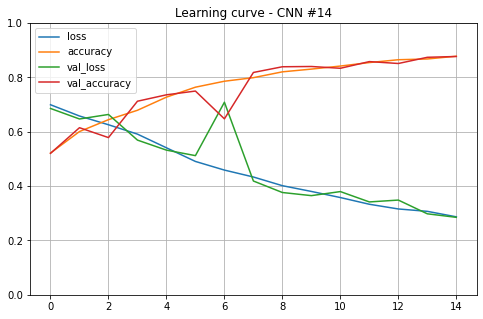

In [192]:
# Plot the learning curve
pd.DataFrame(history_14.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #14')
plt.show()


In [193]:
predict_14 = model_14.predict(X_test)
predict_14

array([[4.1800231e-02],
       [8.5445273e-01],
       [8.2164043e-01],
       ...,
       [8.2545513e-01],
       [2.3570657e-04],
       [9.9999344e-01]], dtype=float32)

In [194]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_14)})
submission_df.to_csv('submission_model_14.csv',index=False)

In [195]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #14', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'ReLu',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.58498'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


# <font color="green">_Treatment 15_</font> 
    
## image resolution: 128x128
## number of channels: 1 (Grayscale)
## hidden Activation function: Tanh
## mini-batch size: 32

In [196]:
model_15 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[128, 128, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [197]:
model_15.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 128)     

In [198]:
model_15.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [199]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_15 = model_15.fit(X_train, np.array(y_train), epochs=15, batch_size=32,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)


Epoch 1/15
625/625 [==============================] - 196s 314ms/step - loss: 0.6232 - accuracy: 0.6594 - val_loss: 0.5223 - val_accuracy: 0.7406
Epoch 2/15
625/625 [==============================] - 188s 301ms/step - loss: 0.5043 - accuracy: 0.7538 - val_loss: 0.4711 - val_accuracy: 0.7732
Epoch 3/15
625/625 [==============================] - 204s 327ms/step - loss: 0.4738 - accuracy: 0.7749 - val_loss: 0.4451 - val_accuracy: 0.7962
Epoch 4/15
625/625 [==============================] - 188s 301ms/step - loss: 0.4618 - accuracy: 0.7827 - val_loss: 0.4721 - val_accuracy: 0.7766
Epoch 5/15
625/625 [==============================] - 187s 300ms/step - loss: 0.4725 - accuracy: 0.7797 - val_loss: 0.4601 - val_accuracy: 0.7892
Epoch 6/15
625/625 [==============================] - 192s 308ms/step - loss: 0.5513 - accuracy: 0.7196 - val_loss: 0.6789 - val_accuracy: 0.5106
Epoch 7/15
625/625 [==============================] - 189s 302ms/step - loss: 0.6968 - accuracy: 0.4956 - val_loss: 0.7029 -

In [200]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_15.history['accuracy'][np.argmin(history_15.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7827

In [201]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_15.history['val_accuracy'][np.argmin(history_15.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7962

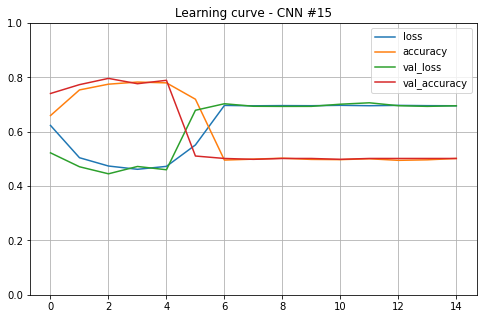

In [202]:
# Plot the learning curve
pd.DataFrame(history_15.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #15')
plt.show()

In [203]:
predict_15 = model_15.predict(X_test)
predict_15

array([[0.53519815],
       [0.53519815],
       [0.53519815],
       ...,
       [0.53519815],
       [0.53519815],
       [0.53519815]], dtype=float32)

In [204]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_15)})
submission_df.to_csv('submission_model_15.csv',index=False)

In [205]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #15', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '32',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '0.69563'
                                   },ignore_index=True)
results_tbl

,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


# <font color="green">_Treatment 16_</font> 
     
## image resolution: 128x128
## number of channels: 1 (Grayscale)
## hidden Activation function: Tanh
## mini-batch size: 256

In [206]:
model_16 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="tanh", input_shape=[128, 128, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(512, kernel_size=(1,1), activation="tanh"),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(120, activation="tanh"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [207]:
model_16.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 14, 14, 128)     

In [208]:
model_16.compile(loss=keras.losses.binary_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [209]:
# Fit the model; obtain the model fit time
start=datetime.now()
history_16 = model_16.fit(X_train, np.array(y_train), epochs=15, batch_size=256,
                    validation_data=(X_valid, np.array(y_valid)))
end=datetime.now()
print(end-start)

Epoch 1/15
79/79 [==============================] - 178s 2s/step - loss: 0.7936 - accuracy: 0.5774 - val_loss: 0.6571 - val_accuracy: 0.6074
Epoch 2/15
79/79 [==============================] - 170s 2s/step - loss: 0.6078 - accuracy: 0.6662 - val_loss: 0.5580 - val_accuracy: 0.7196
Epoch 3/15
79/79 [==============================] - 169s 2s/step - loss: 0.5566 - accuracy: 0.7157 - val_loss: 0.7865 - val_accuracy: 0.6364
Epoch 4/15
79/79 [==============================] - 168s 2s/step - loss: 0.5244 - accuracy: 0.7416 - val_loss: 0.5008 - val_accuracy: 0.7598
Epoch 5/15
79/79 [==============================] - 169s 2s/step - loss: 0.4979 - accuracy: 0.7624 - val_loss: 0.5685 - val_accuracy: 0.7186
Epoch 6/15
79/79 [==============================] - 176s 2s/step - loss: 0.4761 - accuracy: 0.7672 - val_loss: 0.4545 - val_accuracy: 0.7894
Epoch 7/15
79/79 [==============================] - 178s 2s/step - loss: 0.4641 - accuracy: 0.7811 - val_loss: 0.5069 - val_accuracy: 0.7690
Epoch 8/15
79

In [210]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history_16.history['accuracy'][np.argmin(history_16.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8522

In [211]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history_16.history['val_accuracy'][np.argmin(history_16.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8386

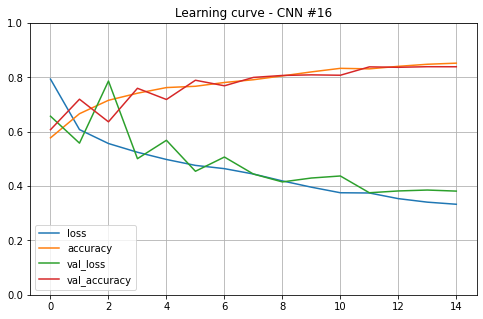

In [212]:
# Plot the learning curve
pd.DataFrame(history_16.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - CNN #16')
plt.show()

In [213]:
predict_16 = model_16.predict(X_test)
predict_16

array([[0.2318491 ],
       [0.7502277 ],
       [0.90832865],
       ...,
       [0.84728813],
       [0.00191206],
       [0.99488795]], dtype=float32)

In [214]:
# save the results to a csv
submission_df = pd.DataFrame({'id':range(1,12501),'label':np.squeeze(predict_16)})
submission_df.to_csv('submission_model_16.csv',index=False)


In [215]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'CNN #16', 
                                   'Image resolution (factor1)':'128x128',
                                   'Number of channels (factor2)':'1',
                                   'Hidden activation function (factor3)':'Tanh',
                                   'Mini-batch size (factor4)': '256',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set Log-Loss (Kaggle score)': '1.56938'
                                   },ignore_index=True)
results_tbl



,Model_name,Image resolution (factor1),Number of channels (factor2),Hidden activation function (factor3),Mini-batch size (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set Log-Loss (Kaggle score)
0,CNN #1,64x64,3,ReLu,32,00:12:05.443494,0.8329,0.8378,1.31343
1,CNN #2,64x64,3,ReLu,256,00:09:39.683880,0.8591,0.8574,1.40166
2,CNN #3,64x64,3,Tanh,32,00:13:47.630460,0.8456,0.8480,1.46957
3,CNN #4,64x64,3,Tanh,256,00:09:48.091970,0.8591,0.8366,1.43507
4,CNN #5,128x128,3,ReLu,32,00:46:05.651385,0.9111,0.9134,2.71841
5,CNN #6,128x128,3,ReLu,256,00:41:25.210938,0.5004,0.5016,0.69315
6,CNN #7,128x128,3,Tanh,32,00:50:43.727092,0.7303,0.7050,0.69562
7,CNN #8,128x128,3,Tanh,256,00:45:42.560195,0.9355,0.8676,2.39295
8,CNN #9,64x64,1,ReLu,32,00:10:27.371470,0.7862,0.8024,1.05215
9,CNN #10,64x64,1,ReLu,256,00:08:31.028115,0.8633,0.8614,1.40932


In [216]:
results_tbl.to_csv("summary_stats.csv")

Kaggle scores: 

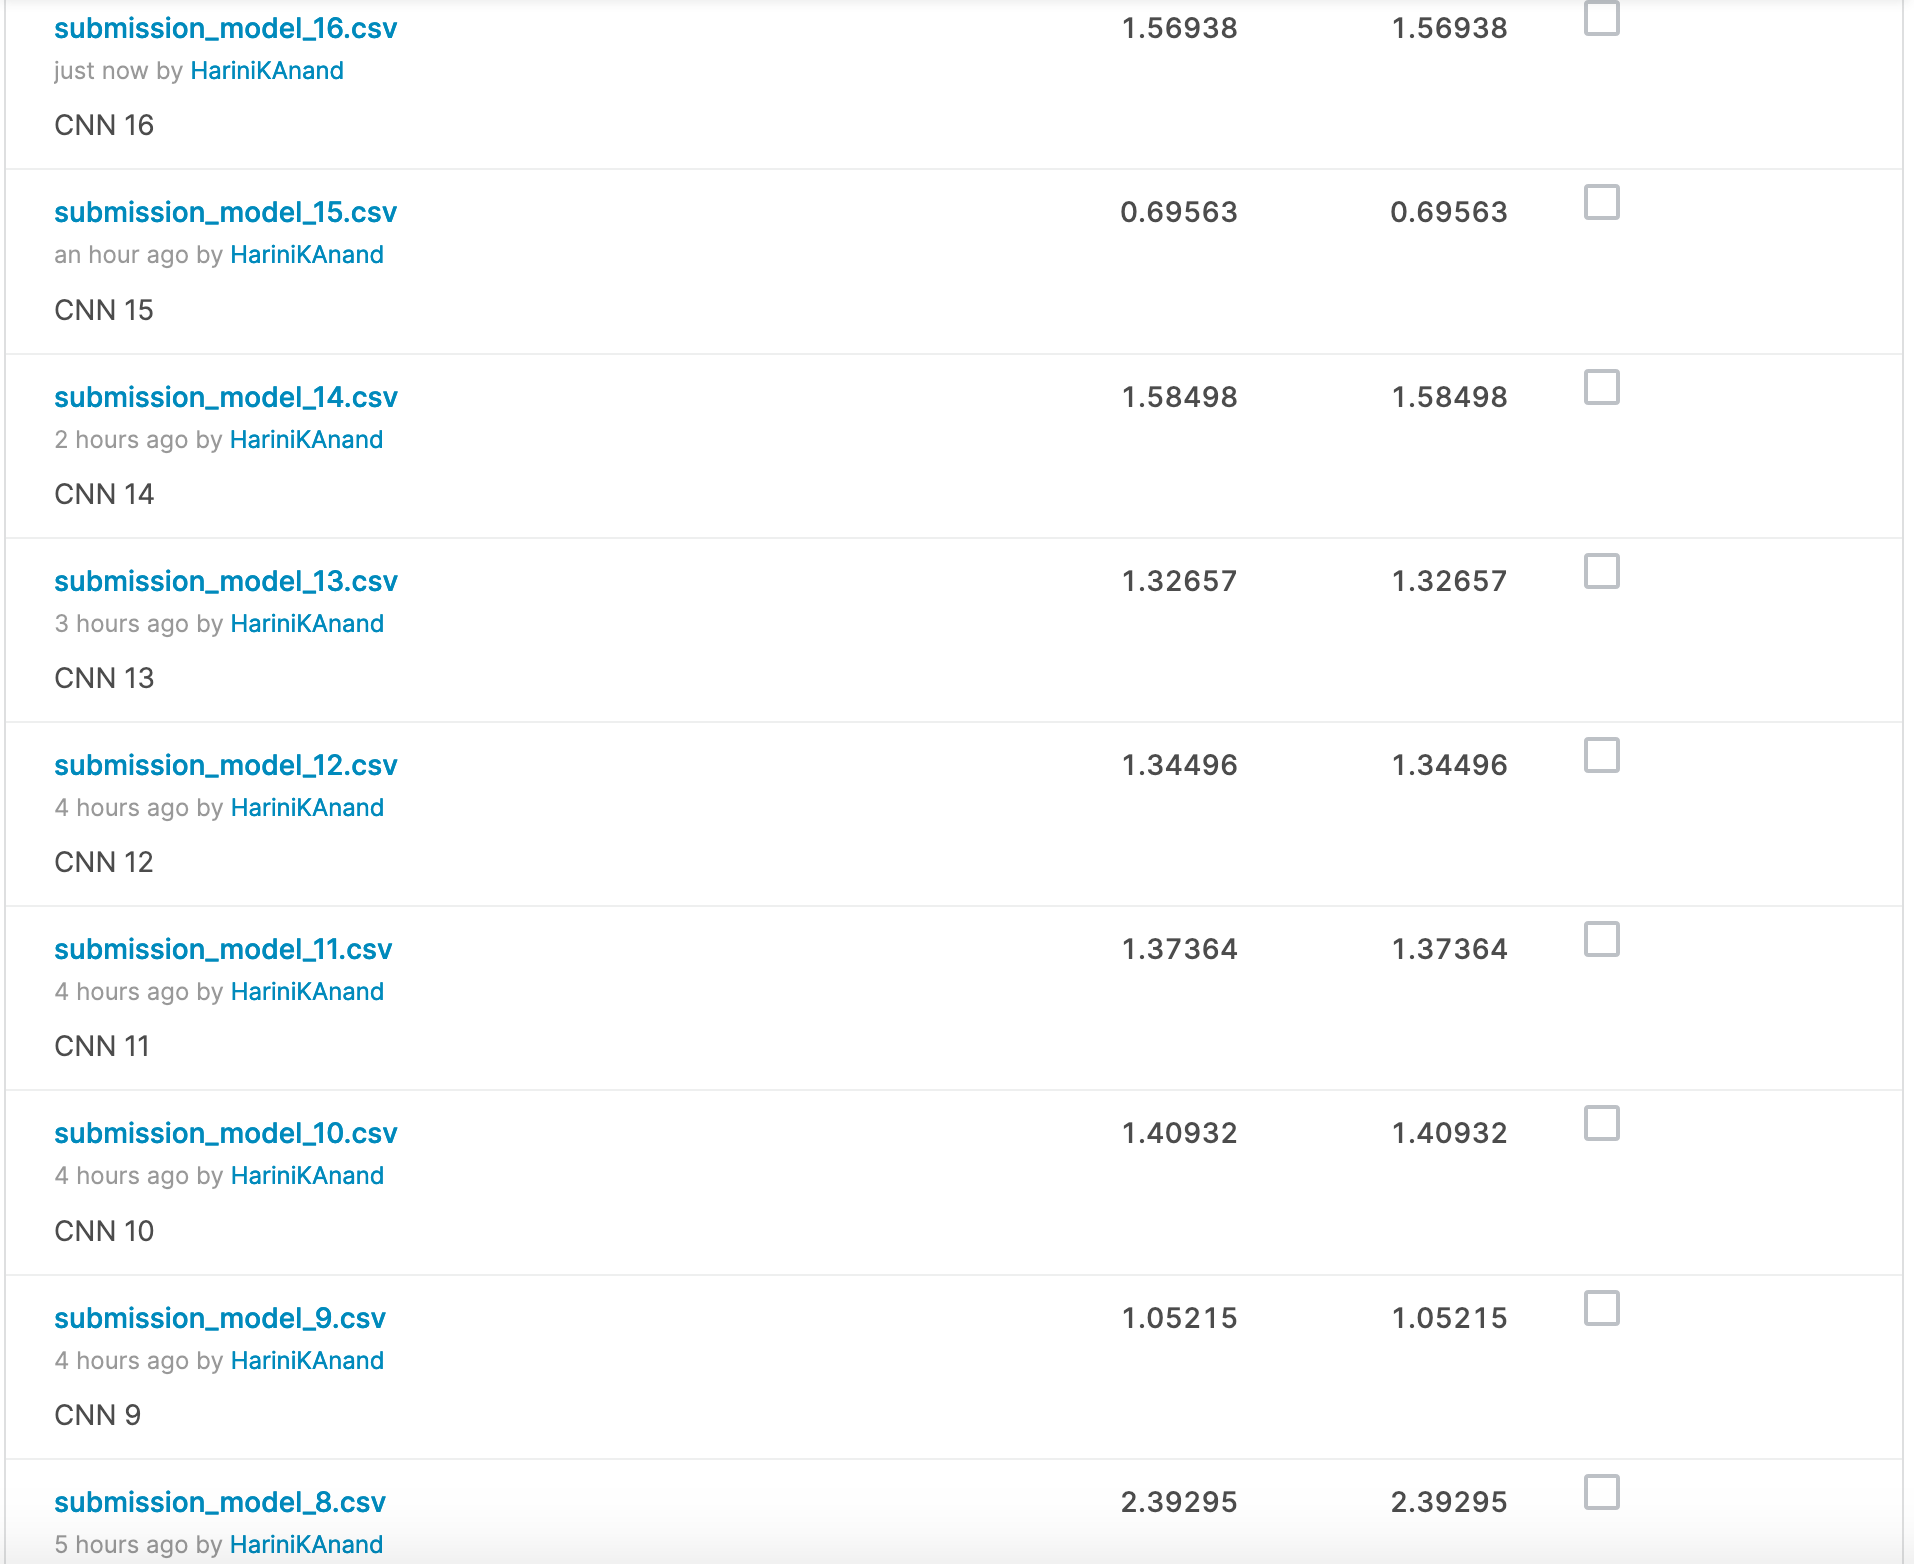

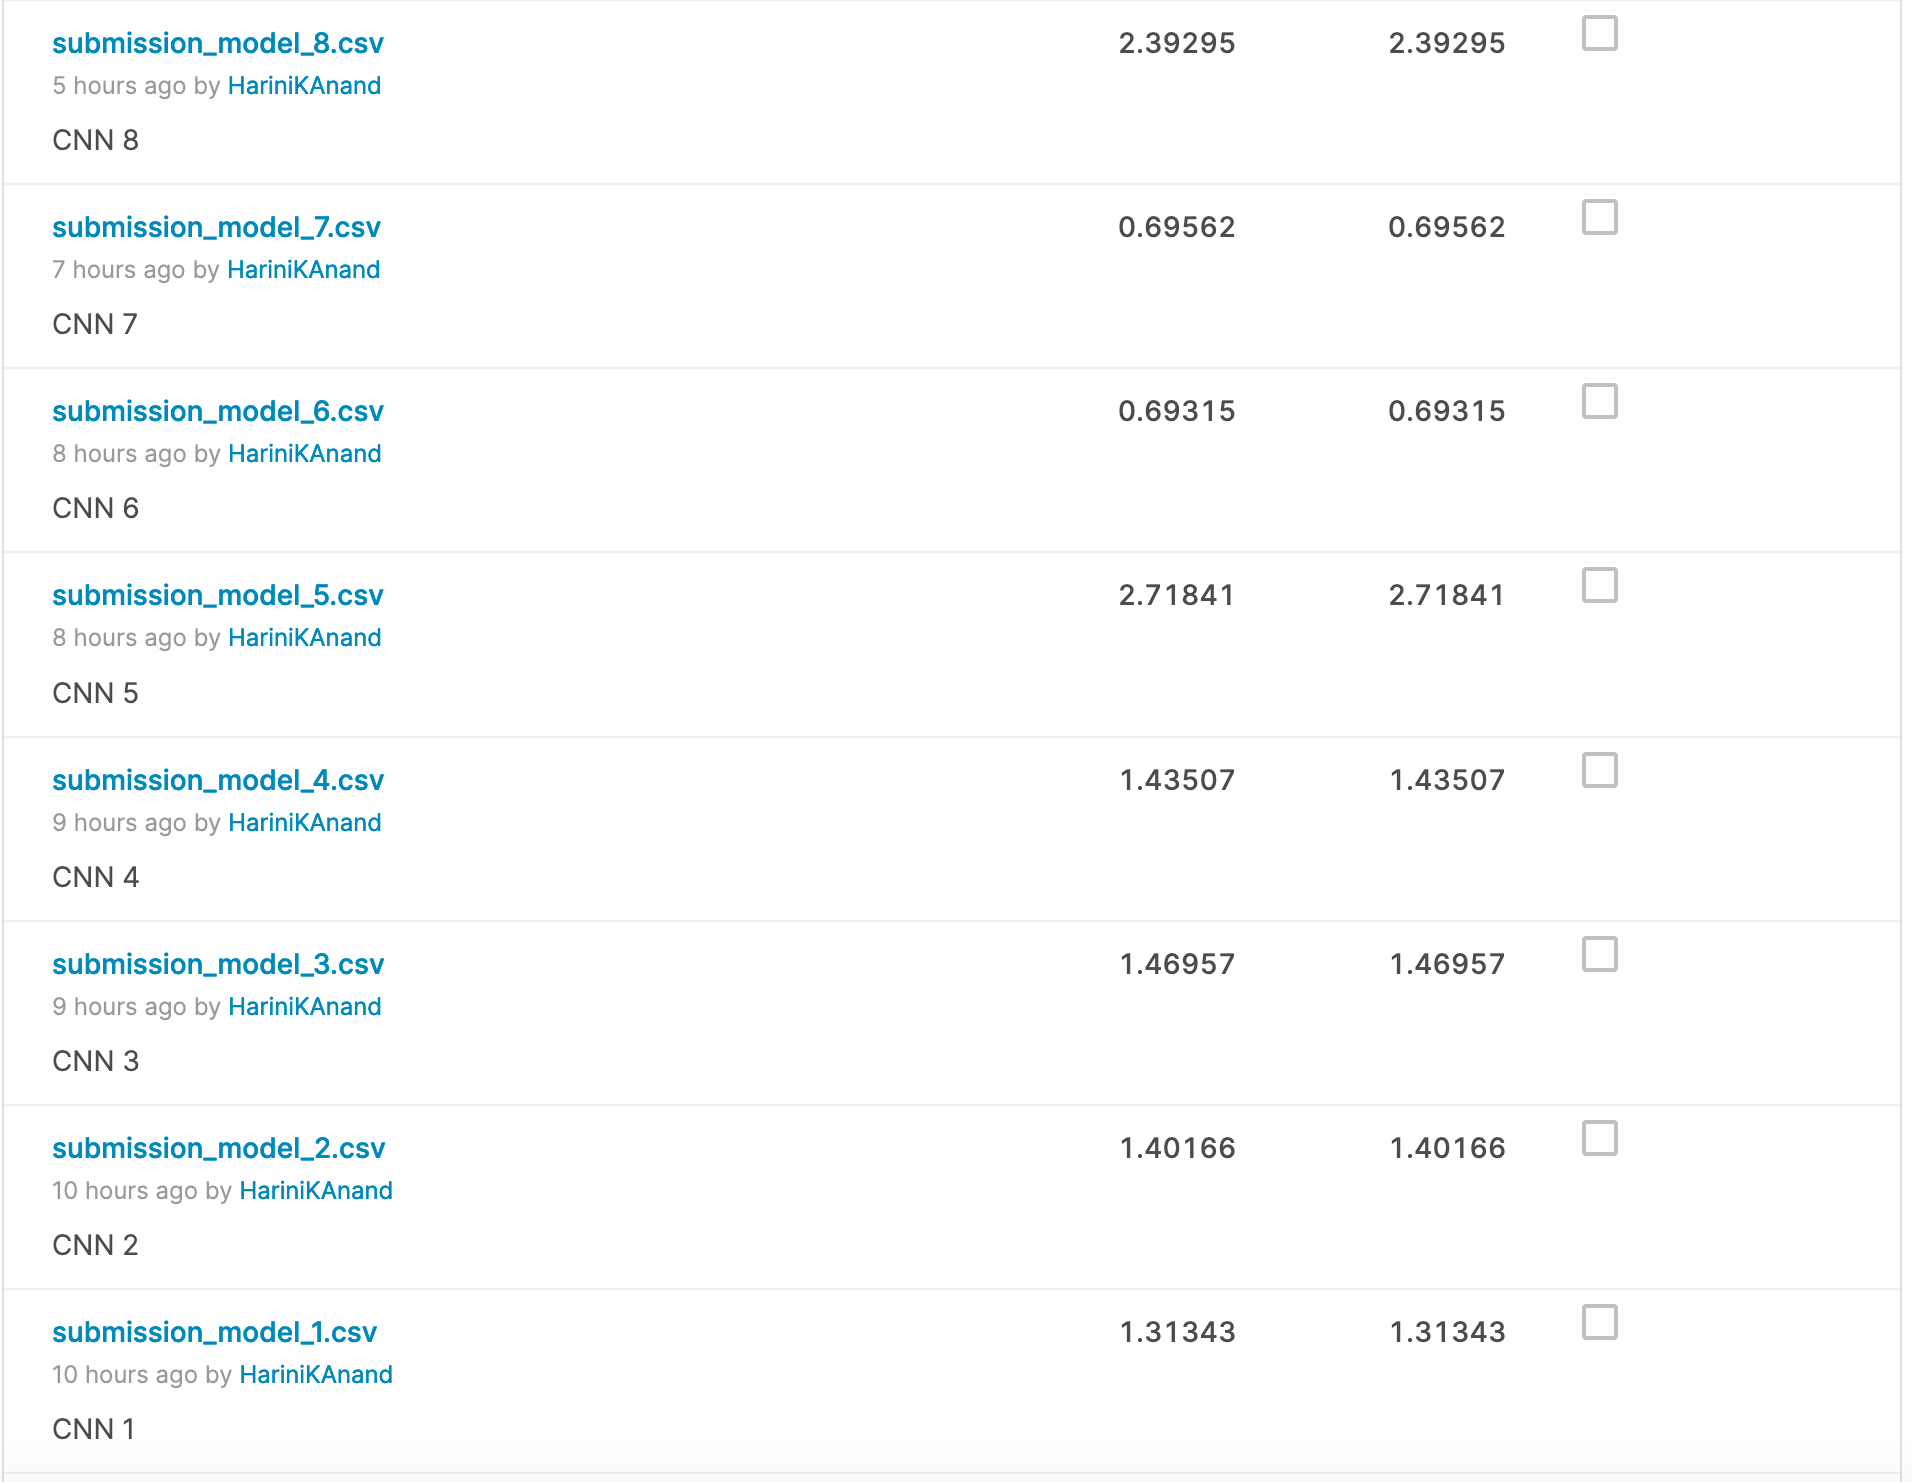